<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span><ul class="toc-item"><li><span><a href="#Изменения-0.1" data-toc-modified-id="Изменения-0.1-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Изменения 0.1</a></span></li></ul></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Обучение-и-выбор-модели" data-toc-modified-id="Обучение-и-выбор-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и выбор модели</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборок" data-toc-modified-id="Разделение-выборок-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Разделение выборок</a></span></li><li><span><a href="#Вспомогашки-и-StandardScaler" data-toc-modified-id="Вспомогашки-и-StandardScaler-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вспомогашки и StandardScaler</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Lasso</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from catboost.metrics import RMSE

!pip install optuna -q
import optuna


pd.set_option('display.max_rows', None)
sns.set(rc={'figure.figsize':(10,6)})

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
df.sample(5)

,datetime,num_orders
19206,2018-07-12 09:00:00,17
1561,2018-03-11 20:10:00,18
16969,2018-06-26 20:10:00,12
9559,2018-05-06 09:10:00,4
5973,2018-04-11 11:30:00,24


In [5]:
class colors:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [6]:
def loses (df):
    len_loses = np.sum(df.isna(), axis=1)!=0
    len_loses = len_loses.sum()
    
    len_data = df.shape[0]
    
    loses_frac = len_loses / len_data
    
    print(f'В выборке {len_loses} строк с пропусками')
    print(f'Это составляет {loses_frac:.2%} от всей выборки')

In [7]:
def data_overview (df):
    print(colors.BOLD + 'Dataset info' + colors.ENDC)
    print(df.info())
    print()
    
    print(colors.BOLD + 'Duplicates:' + colors.ENDC)
    print('Count:', df.duplicated().sum())
    print('Percent:', df.duplicated().sum()/len(df))
    print()
    
    print(colors.BOLD + "NaN's" + colors.ENDC)
    display(pd.concat([df.isna().sum().rename('nan_count'), 
                   df.isna().mean().rename('nan_percent'),
                   df.nunique().rename('unique_values')], 
                  axis=1))
    
    len_loses = np.sum(df.isna(), axis=1)!=0
    len_loses = len_loses.sum()
    len_data = df.shape[0]
    loses_frac = len_loses / len_data
    print(colors.BOLD + f'В выборке {len_loses} строк с пропусками' + colors.ENDC)
    print(colors.BOLD + f'Это составляет {loses_frac:.2%} от всей выборки' + colors.ENDC)


    print()
    
    print(colors.BOLD + 'Numeric cols description' + colors.ENDC)
    print(df.describe())
    df.hist(bins=50, figsize=(19,10))
    #plt.show()
    

Dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

Duplicates:
Count: 0
Percent: 0.0

NaN's


,nan_count,nan_percent,unique_values
datetime,0,0.0,26496
num_orders,0,0.0,81


В выборке 0 строк с пропусками
Это составляет 0.00% от всей выборки

Numeric cols description
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


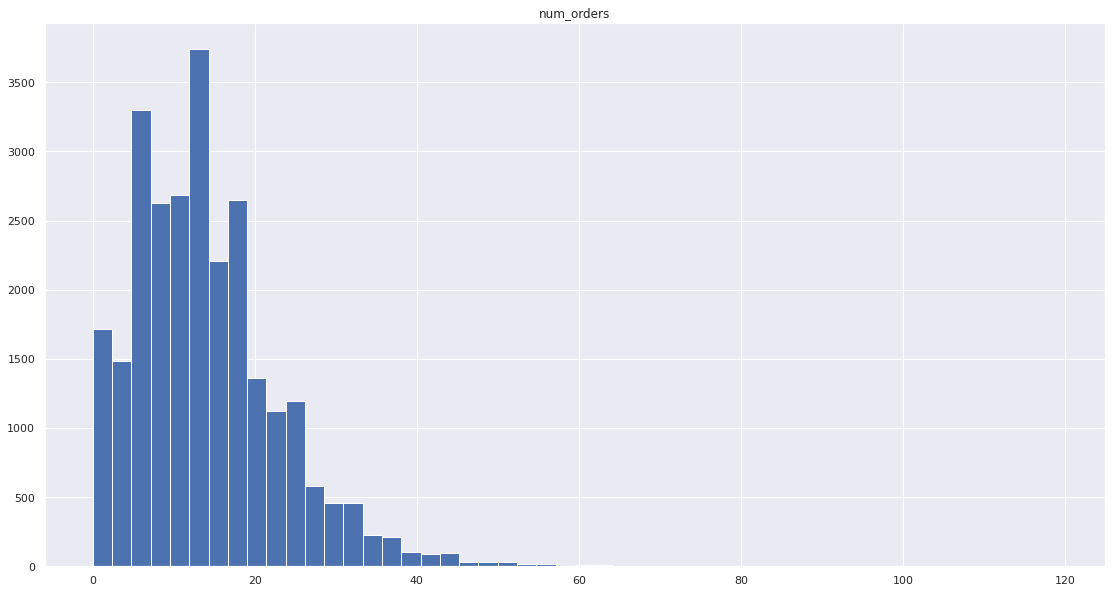

In [8]:
data_overview(df)

In [9]:
df.datetime.head(2), df.datetime.tail(2)

(0    2018-03-01 00:00:00
 1    2018-03-01 00:10:00
 Name: datetime, dtype: object,
 26494    2018-08-31 23:40:00
 26495    2018-08-31 23:50:00
 Name: datetime, dtype: object)

- Представлено 26,5 тыс строк данных
- Содержат 2 параметра: время наблюдения и количество заказов (целевой признак)
- Наблюдения за период 03-08.2018
- Пропусков и дубликатов в данных нет
- Целевой признак имеет тип `int` - Задача регрессии
---
- Нужно привести столбец с датами к правильному типу и отсортировать по увеличению даты (на всякий...)
- И ресемплировать данные по часовым промежуткам

In [10]:
df.datetime = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

In [11]:
df.datetime.head(2), df.datetime.tail(2)

(0   2018-03-01 00:00:00
 1   2018-03-01 00:10:00
 Name: datetime, dtype: datetime64[ns],
 26494   2018-08-31 23:40:00
 26495   2018-08-31 23:50:00
 Name: datetime, dtype: datetime64[ns])

In [12]:
df.set_index('datetime', inplace=True)

In [13]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


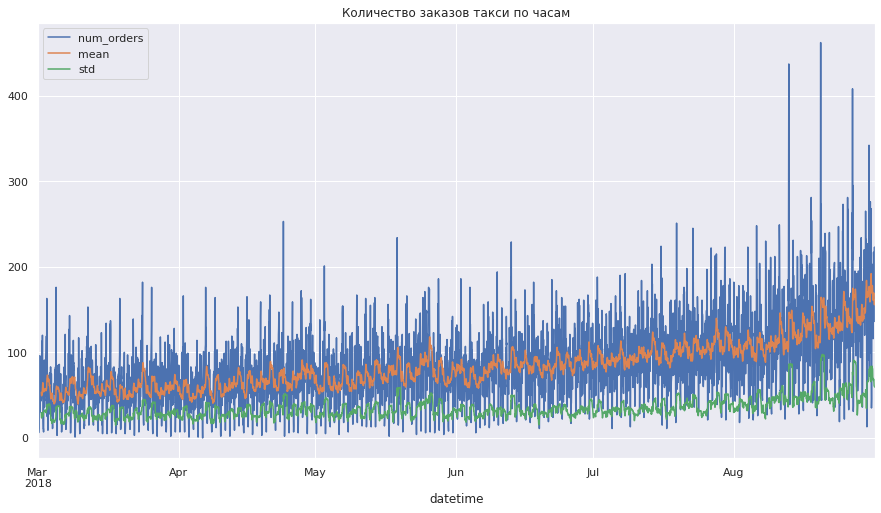

In [14]:
df['mean'] = df['num_orders'].rolling(20).mean()
df['std'] = df['num_orders'].rolling(20).std()
df.plot(figsize=(15,8), title='Количество заказов такси по часам');

Из графика можно понять что наш процесс является _нестационраным_:
- _Стандартное отклонение_ практически не изменяется
- Но _среднее_ за выбранный период увеличивается более чем в 2 раза

In [15]:
df.drop(
    ['std','mean'], 
    axis=1, 
    inplace=True
)

## Анализ

Разложим данные на составляющие

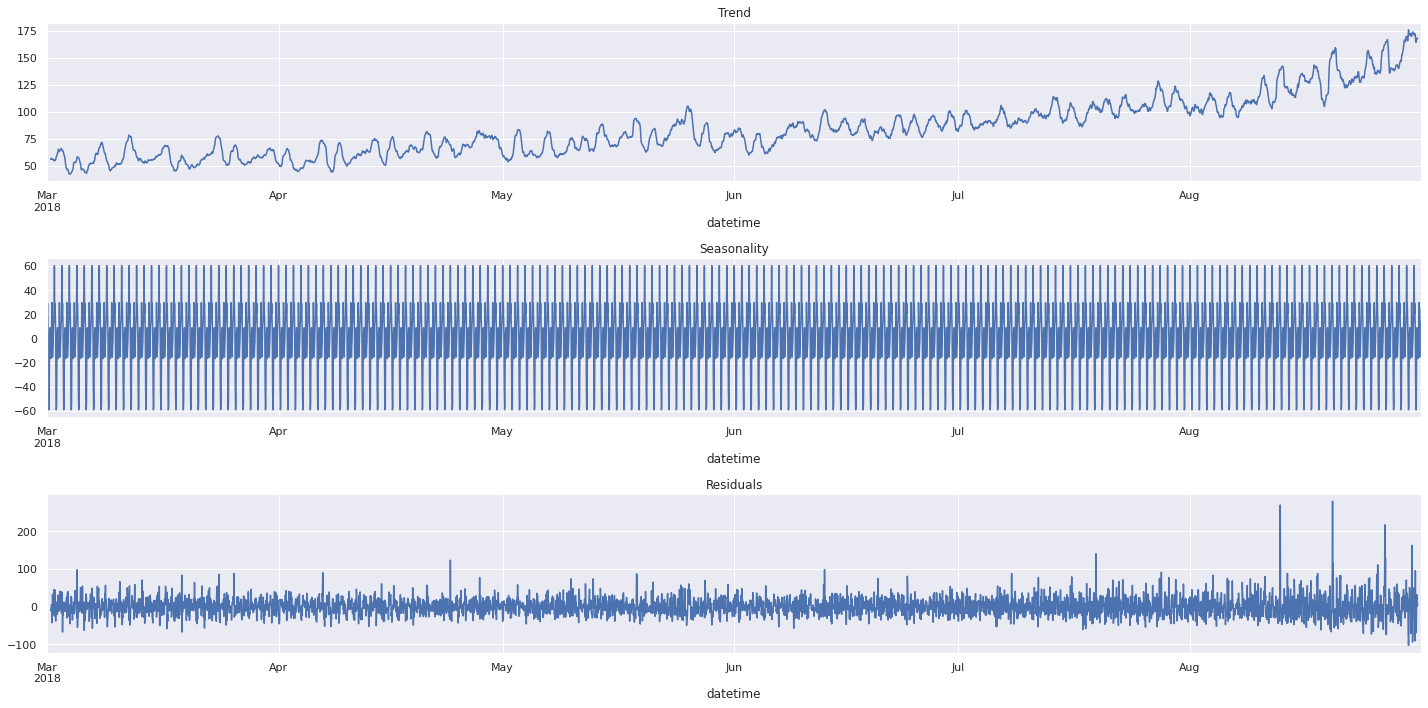

In [16]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(20, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- Можно определить возрастающий тренд на количество заказов
- Сезонность не прослеживается, но мы располагаем данными только по нескольким месяцам одного года
- Остатки колеблятся около нуля без существенных изменений за период измерений. Это просто шум, как и должно быть

Возможно есть некоторые патерны в распределении заказов по часам. Чтобы посмотреть возьмем более короткий отрезок времени и рассмотрим подробнее

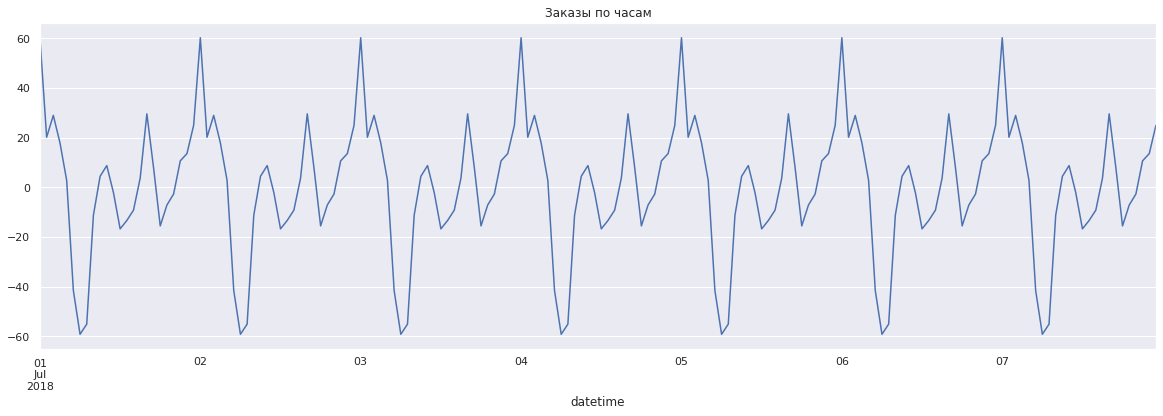

In [17]:
decomposed.seasonal['2018-07-01':'2018-07-7'].plot(
    figsize=(20, 6),
    title = 'Заказы по часам'
);

Прослеживается четкий патерн по количеству заказов в течение дня:
- Максимальное значение около полуночи
- Минимально рано утром

## Feature engineering

Сгенерируем признаки для моделей

In [18]:
def make_features(data, max_lag, rolling_size):
    
    new_data = data.copy()
    new_data['year'] = data.index.year
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    new_data['rolling_std'] = data['num_orders'].shift().rolling(rolling_size).std()
    return new_data

Брать в качестве признаков lag'и в 24 и более часов почти 100% приведет к утечке (учитывая суточный патерн)

In [19]:
df_featured = make_features(df, 23, 5)

In [20]:
df_featured.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение и выбор модели

### Разделение выборок

In [21]:
df_featured.dropna(
    how='any', 
    axis=0,
    inplace=True
)

X = df_featured.drop('num_orders',axis=1)
y = df_featured.num_orders

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    shuffle=False, 
                                                    test_size=.1
                                                   )

In [22]:
print(X_train.index.min(),'-', X_train.index.max())
print()
print(X_test.index.min(),'-', X_test.index.max())

2018-03-01 23:00:00 - 2018-08-13 15:00:00

2018-08-13 16:00:00 - 2018-08-31 23:00:00


### Вспомогашки и StandardScaler

In [23]:
results = pd.DataFrame({'model':[],
                   'rmse':[]})

In [24]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)

    error = predict - actual

    square_error = error ** 2

    mean_square_err = square_error.mean()

    score = np.sqrt(mean_square_err)

    return score

rmse_scorer = make_scorer(rmse, greater_is_better = False)

In [25]:
tscv = TimeSeriesSplit()

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Baseline

In [27]:
model_name = 'Baseline'
base = DummyRegressor(strategy='median')

rmse_score = np.mean(abs(cross_val_score(base,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
rmse_score

41.42573724008065

In [28]:
base.fit(X_train,y_train)

DummyRegressor(strategy='median')

In [29]:
res={'model':model_name,
         'rmse':rmse_score}
results = results.append(res, ignore_index=True)
results

,model,rmse
0,Baseline,41.425737


### CatBoost

In [30]:
model_name = 'CB_simple'
CB = CatBoostRegressor(random_state=42,
                         loss_function='RMSE',
                         silent=True)
CB.fit(X_train, y_train)

In [31]:
rmse_score = np.mean(abs(cross_val_score(CB,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
rmse_score

25.987980351298745

In [32]:
res={'model':model_name,
         'rmse':rmse_score}
results = results.append(res, ignore_index=True)
results

,model,rmse
0,Baseline,41.425737
1,CB_simple,25.987980


---

In [33]:
%%time
model_name = 'CB_optuna'

def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 80, 200),
            'max_depth': trial.suggest_int('max_depth', 4, 15),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.02, 0.5, 0.1]),
            'random_state': 42,
            'silent': True,
            'loss_function': 'RMSE',
    }
    
    model = CatBoostRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=tscv).mean()
    return score

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [34]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 10)
trial = study.best_trial

[I 2022-09-17 13:31:35,017] A new study created in memory with name: no-name-12cf6c7d-4436-4683-bb34-d7d0ca2d24ba
[I 2022-09-17 13:32:00,557] Trial 0 finished with value: -800.198278696822 and parameters: {'n_estimators': 89, 'max_depth': 10, 'learning_rate': 0.5}. Best is trial 0 with value: -800.198278696822.
[I 2022-09-17 13:32:13,318] Trial 1 finished with value: -828.2137899363801 and parameters: {'n_estimators': 190, 'max_depth': 7, 'learning_rate': 0.02}. Best is trial 0 with value: -800.198278696822.
[I 2022-09-17 14:09:08,317] Trial 2 finished with value: -927.7699849728345 and parameters: {'n_estimators': 163, 'max_depth': 15, 'learning_rate': 0.1}. Best is trial 0 with value: -800.198278696822.
[I 2022-09-17 14:09:26,226] Trial 3 finished with value: -818.6564214846123 and parameters: {'n_estimators': 178, 'max_depth': 8, 'learning_rate': 0.5}. Best is trial 0 with value: -800.198278696822.
[I 2022-09-17 14:09:50,455] Trial 4 finished with value: -807.70461480111 and paramet

In [35]:
params = trial.params
CB_opt = CatBoostRegressor(random_state=42, **params)
CB_opt.fit(X_train,y_train,silent=True)

In [36]:
rmse_score = (-1 * trial.value) **.5

In [37]:
res={'model':model_name,
         'rmse':rmse_score}
results = results.append(res, ignore_index=True)
results

,model,rmse
0,Baseline,41.425737
1,CB_simple,25.987980
2,CB_optuna,26.804581


### Lasso

In [38]:
model_name = 'Lasso'

param = {'alpha': [0,.05,.1,.5,1,1.1]}

model = Lasso()
gs_lasso = GridSearchCV(model, 
                        param_grid=param,
                        scoring=rmse_scorer,
                        n_jobs=-1,
                        cv=tscv)
gs_lasso.fit(X_train, y_train)
lasso_opt = gs_lasso.best_estimator_
rmse_score = -1 * gs_lasso.best_score_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160131.26814251527, tolerance: 58.229270588235295
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fi

In [39]:
res={'model':model_name,
         'rmse':rmse_score}
results = results.append(res, ignore_index=True)
results

,model,rmse
0,Baseline,41.425737
1,CB_simple,25.987980
2,CB_optuna,26.804581
3,Lasso,29.286933


Протестируем модели на отложенной выборке

## Тестирование

In [53]:
cb_simple_pred = CB.predict(X_test)
cb_rmse = mean_squared_error(y_test, cb_simple_pred) **.5
cb_rmse

41.791742894781216

In [52]:
cb_pred = CB_opt.predict(X_test)
cb_rmse = mean_squared_error(y_test, cb_pred) **.5
cb_rmse

44.74076497149432

In [54]:
lasso_pred = lasso_opt.predict(X_test)
lasso_rmse = mean_squared_error(y_test, lasso_pred) **.5
lasso_rmse

46.929013342838694

In [55]:
base_pred = base.predict(X_test)
base_rmse = mean_squared_error(y_test,base_pred) **.5
base_rmse

87.21093811714634

In [47]:
y_test.reset_index(drop=True,inplace=True)

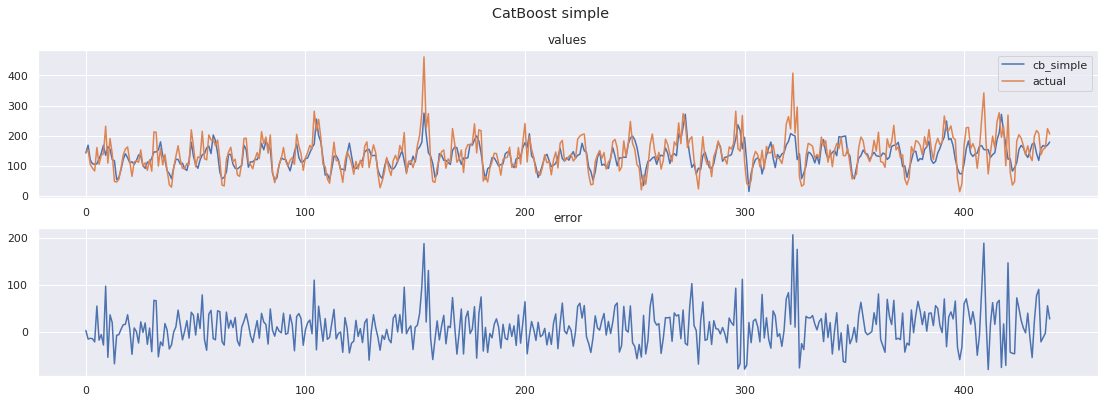

In [64]:
error = y_test - cb_simple_pred

plt.figure(figsize=(19,6))
plt.suptitle('CatBoost simple')
plt.subplot(211)
plt.plot(cb_simple_pred)
plt.plot(y_test)
plt.title('values')
plt.legend(['cb_simple','actual']);
plt.subplot(212)
plt.plot(error)
plt.title('error');

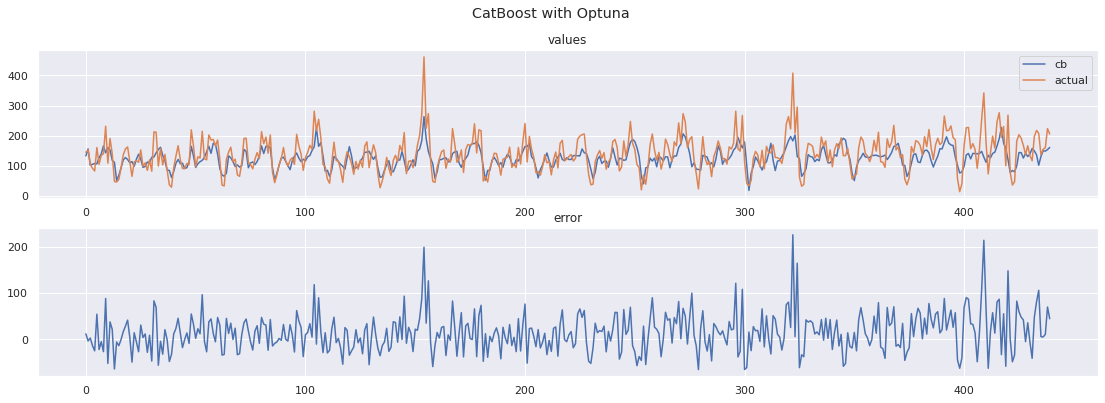

In [65]:
error = y_test - cb_pred

plt.figure(figsize=(19,6))
plt.suptitle('CatBoost with Optuna')
plt.subplot(211)
plt.plot(cb_pred)
plt.plot(y_test)
plt.title('values')
plt.legend(['cb','actual']);
plt.subplot(212)
plt.plot(error)
plt.title('error');

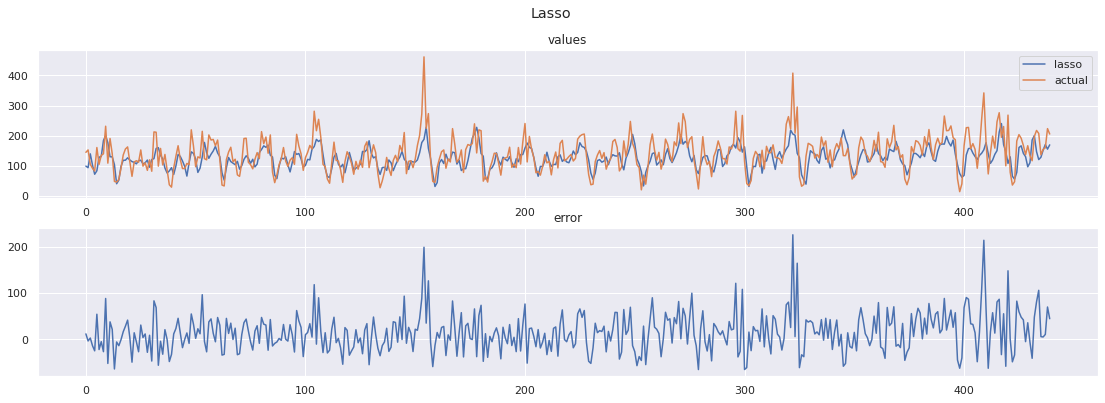

In [66]:
error = y_test - cb_pred

plt.figure(figsize=(19,6))
plt.suptitle('Lasso')
plt.subplot(211)
plt.plot(lasso_pred)
plt.plot(y_test)
plt.title('values')
plt.legend(['lasso','actual']);
plt.subplot(212)
plt.plot(error)
plt.title('error');

Условиям задачи удовлетворяют все обученные модели, но лучшее значение RMSE показал **стандартный CatBoost** со стандартными параметрами

##  Вывод

В рамках проекта были обработаны исторические данные количеству заказов такси компании «Чётенькое такси»

На основании этих данных были сгенерированы признаки для обучения моделей

Лучшей обученной моделью стал стандартный CatBoost с RMSE = 41,78 на тестовой выборке